In [111]:
import pandas as pd
!pip install fastparquet

In [112]:
ls

'Flight Summary - North Atlantic - 2019.pq'   sample_data/


In [143]:
data = pd.read_parquet("Flight Summary - North Atlantic - 2019.pq")

In [144]:
data.head()

,ICAO Aircraft type designator,First known waypoint time (UTC),Last known waypoint time (UTC),Direction,Total flight dist (km),Total fuel burn (kg),Mean overall propulsion efficiency,Aircraft mass mean (kg),Mean nvPM number EI (kg-1),Initial contrail length (km),...,"Ice vol mean radius, Mean (um)","Tau contrail, Mean","Tau cirrus, Mean",RF SW (W m-2),RF LW (W m-2),RF Net (W m-2),Total contrail EF (J),SDR mean (W m-2),RSR mean (W m-2),OLR mean (W m-2)
0,B772,2019-01-01 02:17:49,2019-01-01 05:18:26,E,2633.994219,23991.530999,0.311201,228553.082349,4.920940e+14,1415.515126,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
1,B763,2019-01-01 02:19:06,2019-01-01 05:27:55,E,2670.997754,13886.660380,0.325782,150812.984413,1.425808e+15,1701.125144,...,3.716948,0.090483,0.001725,-0.565425,4.231059,3.665634,1.515245e+14,36.862724,15.583469,238.200396
2,B763,2019-01-01 02:21:40,2019-01-01 05:11:34,E,2388.740516,13397.610853,0.304915,150872.338643,1.172578e+15,2388.740516,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
3,B744,2019-01-01 02:16:31,2019-01-01 05:44:38,E,3039.310160,38210.558395,0.317271,311350.241271,5.589923e+14,2216.876721,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
4,B789,2019-01-01 03:15:00,2019-01-01 04:30:15,E,1092.545055,9686.423444,0.282729,212017.428561,8.404441e+14,1092.545055,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000


At this stage - we begin by experimenting as to whether or not we can predict "persistent contrail formation"

Given the atmospheric and flight data we have - can we predict whether or not a persistent contrail will form?

In [145]:
# We set aside our target variable in this case - 1 if a a persisent contrail has a length > 0 , 0 otherwise

data['PersistentContrail_Formed'] = data['Persistent contrail length (km)'].apply(lambda x: 1 if x > 0 else 0)

In [146]:
# Next we do some feature engineering to deduce temporal characteristics about a flight given the waypoint times

# Convert the string columns to datetime
data['First known waypoint time (UTC)'] = pd.to_datetime(data['First known waypoint time (UTC)'])
data['Last known waypoint time (UTC)'] = pd.to_datetime(data['Last known waypoint time (UTC)'])

# Compute flight duration between waypoints, Time of Day and Month
data['Flight Duration'] = (data['Last known waypoint time (UTC)'] - data['First known waypoint time (UTC)']).dt.total_seconds()
data['Time of Day'] = data['First known waypoint time (UTC)'].dt.hour
data['Month'] = data['First known waypoint time (UTC)'].dt.month

With our list of features in hand - we need to understand which of them are most important in understanding our target variable - in this case, persistent contrail formation. The correlation matrix we used in our EDA highlights linear relationships but we need to understand the possibilty of nonlinear relationships as well.

Our input feature space should be a list of features that have the highest linear and/or nonlinear relationships with our data. That will inform us which model is most effective in forecasting our target.


In [147]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# For Label Encoding (Example: 'Direction' column)
le = LabelEncoder()
data['Direction_encoded'] = le.fit_transform(data['Direction'])

# This will create new columns like 'B772', 'B763', etc. and will drop the original 'ICAO Aircraft type designator' column
data = pd.get_dummies(data, columns=['ICAO Aircraft type designator'], drop_first=True)

In [148]:
data.head()

,First known waypoint time (UTC),Last known waypoint time (UTC),Direction,Total flight dist (km),Total fuel burn (kg),Mean overall propulsion efficiency,Aircraft mass mean (kg),Mean nvPM number EI (kg-1),Initial contrail length (km),First contrail waypoint time (UTC),...,ICAO Aircraft type designator_MD83,ICAO Aircraft type designator_P1,ICAO Aircraft type designator_P28A,ICAO Aircraft type designator_P3,ICAO Aircraft type designator_P8,ICAO Aircraft type designator_PC12,ICAO Aircraft type designator_R135,ICAO Aircraft type designator_R721,ICAO Aircraft type designator_SW4,ICAO Aircraft type designator_T204
0,2019-01-01 02:17:49,2019-01-01 05:18:26,E,2633.994219,23991.530999,0.311201,228553.082349,4.920940e+14,1415.515126,None,...,0,0,0,0,0,0,0,0,0,0
1,2019-01-01 02:19:06,2019-01-01 05:27:55,E,2670.997754,13886.660380,0.325782,150812.984413,1.425808e+15,1701.125144,2019-01-01 03:57:00,...,0,0,0,0,0,0,0,0,0,0
2,2019-01-01 02:21:40,2019-01-01 05:11:34,E,2388.740516,13397.610853,0.304915,150872.338643,1.172578e+15,2388.740516,None,...,0,0,0,0,0,0,0,0,0,0
3,2019-01-01 02:16:31,2019-01-01 05:44:38,E,3039.310160,38210.558395,0.317271,311350.241271,5.589923e+14,2216.876721,None,...,0,0,0,0,0,0,0,0,0,0
4,2019-01-01 03:15:00,2019-01-01 04:30:15,E,1092.545055,9686.423444,0.282729,212017.428561,8.404441e+14,1092.545055,None,...,0,0,0,0,0,0,0,0,0,0


In [188]:
exclude_features = [
    'PersistentContrail_Formed',  # this is the target variable
    'Persistent contrail length (km)',
    'Contrail altitude initial, Mean (ft)',
    'Contrail altitude lifetime, Mean (ft)',
    'Contrail age, Mean (h)',
    'Contrail age, Max (h)',
    'Initial contrail length (km)',
    'First known waypoint time (UTC)',
    'Last known waypoint time (UTC)',
    'Direction'
]

X = data.drop(columns=exclude_features)

In [189]:
contrail_columns = [col for col in X.columns if 'contrail' in col.lower()]
X = X.drop(columns=contrail_columns)

In [190]:
y = data['PersistentContrail_Formed']

In [191]:
X.head()

,Total flight dist (km),Total fuel burn (kg),Mean overall propulsion efficiency,Aircraft mass mean (kg),Mean nvPM number EI (kg-1),"RHi initial, Mean","RHi initial, Stdev","RHi lifetime, Mean","Temp initial, Mean (K)","Temp initial, Stdev (K)",...,ICAO Aircraft type designator_MD83,ICAO Aircraft type designator_P1,ICAO Aircraft type designator_P28A,ICAO Aircraft type designator_P3,ICAO Aircraft type designator_P8,ICAO Aircraft type designator_PC12,ICAO Aircraft type designator_R135,ICAO Aircraft type designator_R721,ICAO Aircraft type designator_SW4,ICAO Aircraft type designator_T204
0,2633.994219,23991.530999,0.311201,228553.082349,4.920940e+14,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,2670.997754,13886.660380,0.325782,150812.984413,1.425808e+15,1.079427,0.095837,1.090244,213.532187,0.195622,...,0,0,0,0,0,0,0,0,0,0
2,2388.740516,13397.610853,0.304915,150872.338643,1.172578e+15,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,3039.310160,38210.558395,0.317271,311350.241271,5.589923e+14,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,1092.545055,9686.423444,0.282729,212017.428561,8.404441e+14,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [153]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

# Drop non-numeric columns
X = X.select_dtypes(exclude=['datetime64'])

rf.fit(X, y)

RandomForestClassifier()

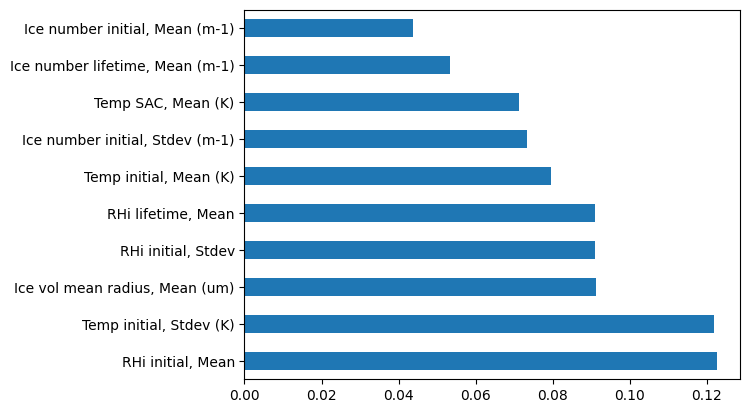

In [154]:
feature_importance = pd.Series(rf.feature_importances_, index=X.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.show()

In [155]:
feature_importance.nlargest(10)

RHi initial, Mean                  0.122585
Temp initial, Stdev (K)            0.121806
Ice vol mean radius, Mean (um)     0.091273
RHi initial, Stdev                 0.090938
RHi lifetime, Mean                 0.090851
Temp initial, Mean (K)             0.079542
Ice number initial, Stdev (m-1)    0.073273
Temp SAC, Mean (K)                 0.071120
Ice number lifetime, Mean (m-1)    0.053227
Ice number initial, Mean (m-1)     0.043798
dtype: float64

In [160]:
feature_importance.nlargest(10).index.values

array(['RHi initial, Mean', 'Temp initial, Stdev (K)',
       'Ice vol mean radius, Mean (um)', 'RHi initial, Stdev',
       'RHi lifetime, Mean', 'Temp initial, Mean (K)',
       'Ice number initial, Stdev (m-1)', 'Temp SAC, Mean (K)',
       'Ice number lifetime, Mean (m-1)',
       'Ice number initial, Mean (m-1)'], dtype=object)

RHi initial, Stdev: This represents the standard deviation of the initial relative humidity with respect to ice (RHi). Higher variability in initial conditions could significantly influence contrail formation.

Ice number initial, Mean (m-1): The mean initial number of ice particles. Ice nucleation is crucial for contrail formation, so it's not surprising that this feature is significant.

RHi lifetime, Mean: This might represent the mean RHi value over the contrail's lifetime. Persistent contrails tend to form in regions of higher relative humidity.

Ice number initial, Stdev (m-1): Variation in the initial number of ice particles may impact contrail persistence.

RHi initial, Mean: The mean initial RHi. Like the third feature, this is direct evidence of how humidity impacts contrail formation.

Ice number lifetime, Mean (m-1): The average number of ice particles over the contrail's lifetime can hint at the persistence of the contrail.

Temp SAC, Stdev (K): Temperature variability might be linked to atmospheric conditions conducive to contrail formation.

RSR mean (W m-2): Reflected Shortwave Radiation. This could relate to how contrails interact with solar radiation, influencing climate.

Temp initial, Stdev (K): Variability in the initial temperature conditions. Contrails typically form at colder temperatures.

RF LW (W m-2): Longwave Radiative Forcing. Contrails can affect the Earth's radiative balance, influencing warming or cooling effects.

In [192]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

top_features = feature_importance.nlargest(10).index
X_top = X[top_features]

In [193]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)

# Define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

In [165]:
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.4420
Decision Tree Accuracy: 1.0000
Random Forest Accuracy: 1.0000


In [166]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [167]:
logreg = LogisticRegression(max_iter=2000, solver='sag')  # Increased iterations and changed solver
logreg.fit(X_train_scaled, y_train)
y_pred_logreg = logreg.predict(X_test_scaled)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Logistic Regression (Scaled Features) Accuracy: {accuracy_logreg:.4f}")

Logistic Regression (Scaled Features) Accuracy: 1.0000


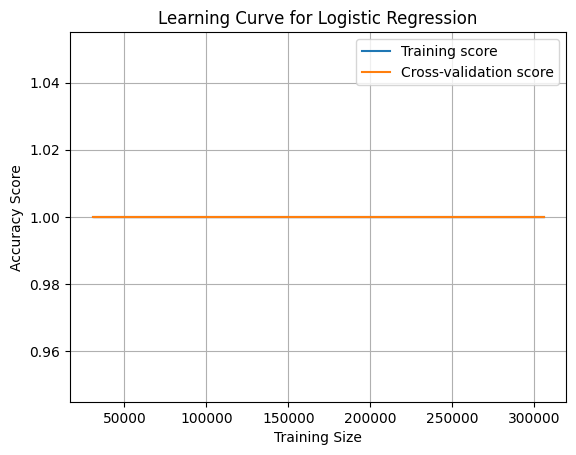

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Generate the learning curve
train_sizes, train_scores, valid_scores = learning_curve(logreg, X_train_scaled, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy')

# Calculate mean and standard deviation for training set sizes
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_mean, label='Training score')
plt.plot(train_sizes, valid_mean, label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, color="#DDDDDD")
plt.title('Learning Curve for Logistic Regression')
plt.xlabel('Training Size')
plt.ylabel('Accuracy Score')
plt.legend(loc='best')
plt.grid()
plt.show()


In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

target = 'PersistentContrail_Formed'

features = [
    'RHi initial, Stdev',
    'Ice number initial, Mean (m-1)',
    'RHi lifetime, Mean',
    'Ice number initial, Stdev (m-1)',
    'RHi initial, Mean',
    'Ice number lifetime, Mean (m-1)',
    'Temp SAC, Stdev (K)',
    'RSR mean (W m-2)',
    'Temp initial, Stdev (K)',
    'RF LW (W m-2)'
]

for feature in features:
    model = LinearRegression()

    X = data[feature].values.reshape(-1, 1)
    y = data[target]

    model.fit(X, y)

    predictions = model.predict(X)

    # Calculate R^2 and MSE
    r2 = r2_score(y, predictions)
    mse = mean_squared_error(y, predictions)

    print(f"Feature: {feature}")
    print(f"R^2: {r2:.3f}")
    print(f"MSE: {mse:.3f}")
    print("-----")


Feature: RHi initial, Stdev
R^2: 0.621
MSE: 0.094
-----
Feature: Ice number initial, Mean (m-1)
R^2: 0.576
MSE: 0.105
-----
Feature: RHi lifetime, Mean
R^2: 0.987
MSE: 0.003
-----
Feature: Ice number initial, Stdev (m-1)
R^2: 0.495
MSE: 0.125
-----
Feature: RHi initial, Mean
R^2: 0.977
MSE: 0.006
-----
Feature: Ice number lifetime, Mean (m-1)
R^2: 0.483
MSE: 0.128
-----
Feature: Temp SAC, Stdev (K)
R^2: 0.551
MSE: 0.111
-----
Feature: RSR mean (W m-2)
R^2: 0.297
MSE: 0.173
-----
Feature: Temp initial, Stdev (K)
R^2: 0.337
MSE: 0.163
-----
Feature: RF LW (W m-2)
R^2: 0.386
MSE: 0.151
-----


In [194]:
lifetime_columns = [col for col in X.columns if 'lifetime' in col.lower()]
X = X.drop(columns=lifetime_columns)

In [195]:
X.head()

,Total flight dist (km),Total fuel burn (kg),Mean overall propulsion efficiency,Aircraft mass mean (kg),Mean nvPM number EI (kg-1),"RHi initial, Mean","RHi initial, Stdev","Temp initial, Mean (K)","Temp initial, Stdev (K)","Temp SAC, Mean (K)",...,ICAO Aircraft type designator_MD83,ICAO Aircraft type designator_P1,ICAO Aircraft type designator_P28A,ICAO Aircraft type designator_P3,ICAO Aircraft type designator_P8,ICAO Aircraft type designator_PC12,ICAO Aircraft type designator_R135,ICAO Aircraft type designator_R721,ICAO Aircraft type designator_SW4,ICAO Aircraft type designator_T204
0,2633.994219,23991.530999,0.311201,228553.082349,4.920940e+14,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,2670.997754,13886.660380,0.325782,150812.984413,1.425808e+15,1.079427,0.095837,213.532187,0.195622,224.165862,...,0,0,0,0,0,0,0,0,0,0
2,2388.740516,13397.610853,0.304915,150872.338643,1.172578e+15,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,3039.310160,38210.558395,0.317271,311350.241271,5.589923e+14,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,1092.545055,9686.423444,0.282729,212017.428561,8.404441e+14,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [177]:
X_train.head()

,Total flight dist (km),Total fuel burn (kg),Mean overall propulsion efficiency,Aircraft mass mean (kg),Mean nvPM number EI (kg-1),"RHi initial, Mean","RHi initial, Stdev","Temp initial, Mean (K)","Temp initial, Stdev (K)","Temp SAC, Mean (K)",...,ICAO Aircraft type designator_MD83,ICAO Aircraft type designator_P1,ICAO Aircraft type designator_P28A,ICAO Aircraft type designator_P3,ICAO Aircraft type designator_P8,ICAO Aircraft type designator_PC12,ICAO Aircraft type designator_R135,ICAO Aircraft type designator_R721,ICAO Aircraft type designator_SW4,ICAO Aircraft type designator_T204
422859,1737.842717,17982.064438,0.343370,287161.731634,5.174123e+14,1.117948,0.042368,216.407696,0.234050,225.324855,...,0,0,0,0,0,0,0,0,0,0
116024,2295.479710,13434.138460,0.325865,179510.076542,1.622568e+15,1.114488,0.041358,213.677131,0.154528,223.942500,...,0,0,0,0,0,0,0,0,0,0
320491,2478.534699,18162.723447,0.280150,188332.835243,7.533477e+14,0.978259,0.030932,216.631511,0.293267,220.453619,...,0,0,0,0,0,0,0,0,0,0
307868,3166.610952,28381.852098,0.338099,227237.525071,5.194762e+14,1.088252,0.078272,218.609242,1.260353,223.962274,...,0,0,0,0,0,0,0,0,0,0
341460,2614.460947,24645.289590,0.289533,227111.539269,4.543342e+14,1.190498,0.187176,213.952132,1.082388,223.208425,...,0,0,0,0,0,0,0,0,0,0


In [178]:
y.head()

0    0
1    1
2    0
3    0
4    0
Name: PersistentContrail_Formed, dtype: int64

In [179]:
rf.fit(X, y)

RandomForestClassifier()

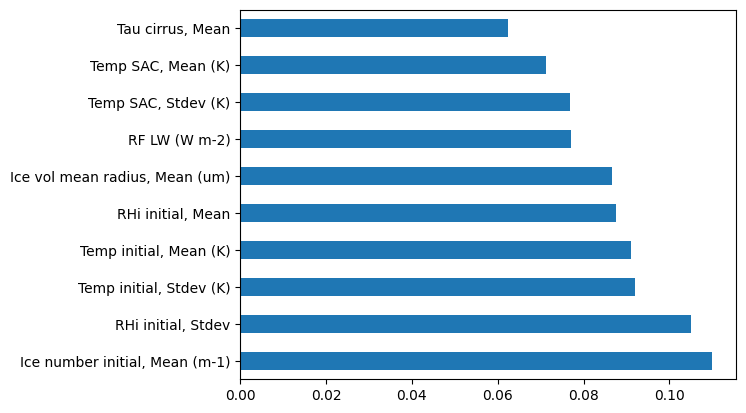

In [180]:
feature_importance = pd.Series(rf.feature_importances_, index=X.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.show()

In [181]:
feature_importance.nlargest(10)

Ice number initial, Mean (m-1)    0.110038
RHi initial, Stdev                0.104977
Temp initial, Stdev (K)           0.092075
Temp initial, Mean (K)            0.090965
RHi initial, Mean                 0.087494
Ice vol mean radius, Mean (um)    0.086714
RF LW (W m-2)                     0.077122
Temp SAC, Stdev (K)               0.076793
Temp SAC, Mean (K)                0.071283
Tau cirrus, Mean                  0.062393
dtype: float64

In [182]:
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")

Logistic Regression Accuracy: 1.0000
Decision Tree Accuracy: 1.0000
Random Forest Accuracy: 1.0000


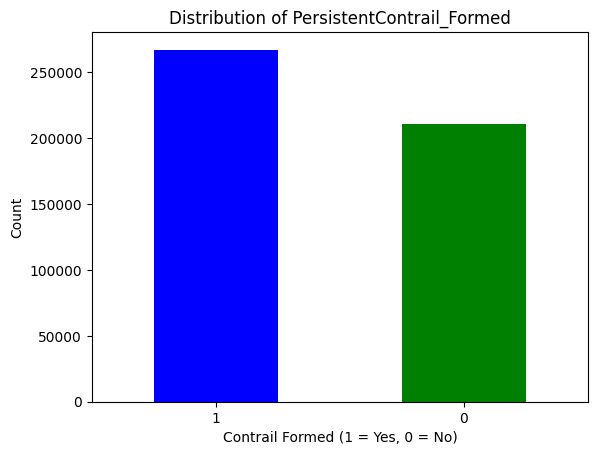

In [175]:
import matplotlib.pyplot as plt

# Count the occurrences of each value in the 'PersistentContrail_Formed' column
value_counts = data['PersistentContrail_Formed'].value_counts()

# Plotting the distribution
value_counts.plot(kind='bar', color=['blue', 'green'])
plt.title('Distribution of PersistentContrail_Formed')
plt.xlabel('Contrail Formed (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


In [183]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

target = 'PersistentContrail_Formed'

features = feature_importance.nlargest(10).index

for feature in features:
    model = LinearRegression()

    X = data[feature].values.reshape(-1, 1)
    y = data[target]

    model.fit(X, y)

    predictions = model.predict(X)

    # Calculate R^2 and MSE
    r2 = r2_score(y, predictions)
    mse = mean_squared_error(y, predictions)

    print(f"Feature: {feature}")
    print(f"R^2: {r2:.3f}")
    print(f"MSE: {mse:.3f}")
    print("-----")

Feature: Ice number initial, Mean (m-1)
R^2: 0.576
MSE: 0.105
-----
Feature: RHi initial, Stdev
R^2: 0.621
MSE: 0.094
-----
Feature: Temp initial, Stdev (K)
R^2: 0.337
MSE: 0.163
-----
Feature: Temp initial, Mean (K)
R^2: 0.999
MSE: 0.000
-----
Feature: RHi initial, Mean
R^2: 0.977
MSE: 0.006
-----
Feature: Ice vol mean radius, Mean (um)
R^2: 0.512
MSE: 0.120
-----
Feature: RF LW (W m-2)
R^2: 0.386
MSE: 0.151
-----
Feature: Temp SAC, Stdev (K)
R^2: 0.551
MSE: 0.111
-----
Feature: Temp SAC, Mean (K)
R^2: 1.000
MSE: 0.000
-----
Feature: Tau cirrus, Mean
R^2: 0.227
MSE: 0.191
-----


In [197]:
X['Temp initial, Mean (K)']

0           0.000000
1         213.532187
2           0.000000
3           0.000000
4           0.000000
             ...    
477918    210.201732
477919    210.874679
477920    207.150386
477921    216.861311
477922    205.355716
Name: Temp initial, Mean (K), Length: 477923, dtype: float64

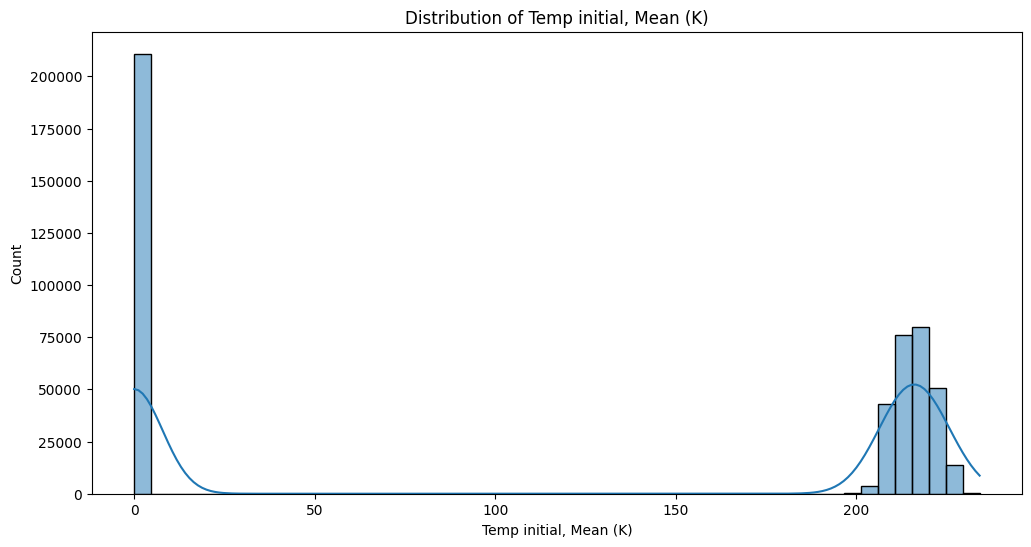

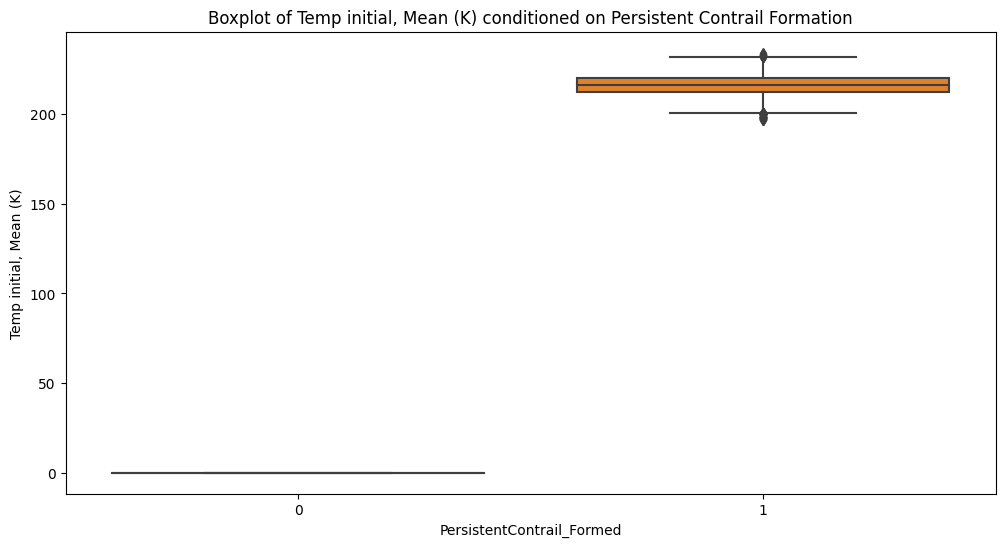

In [198]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of the feature
plt.figure(figsize=(12, 6))
sns.histplot(X['Temp initial, Mean (K)'], bins=50, kde=True)
plt.title('Distribution of Temp initial, Mean (K)')
plt.show()

# Box plots conditioned on the target variable
plt.figure(figsize=(12, 6))
sns.boxplot(x=y, y=X['Temp initial, Mean (K)'])
plt.title('Boxplot of Temp initial, Mean (K) conditioned on Persistent Contrail Formation')
plt.show()


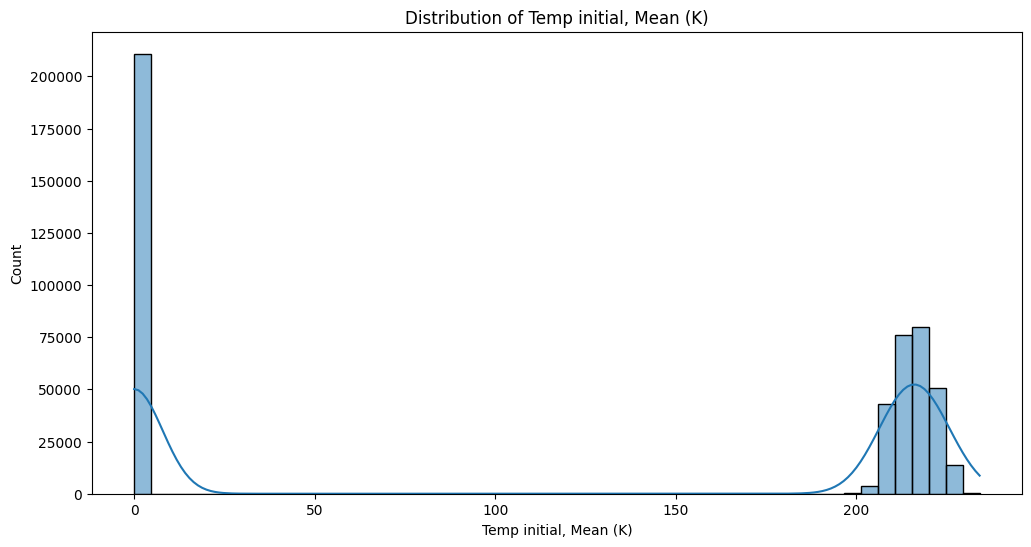

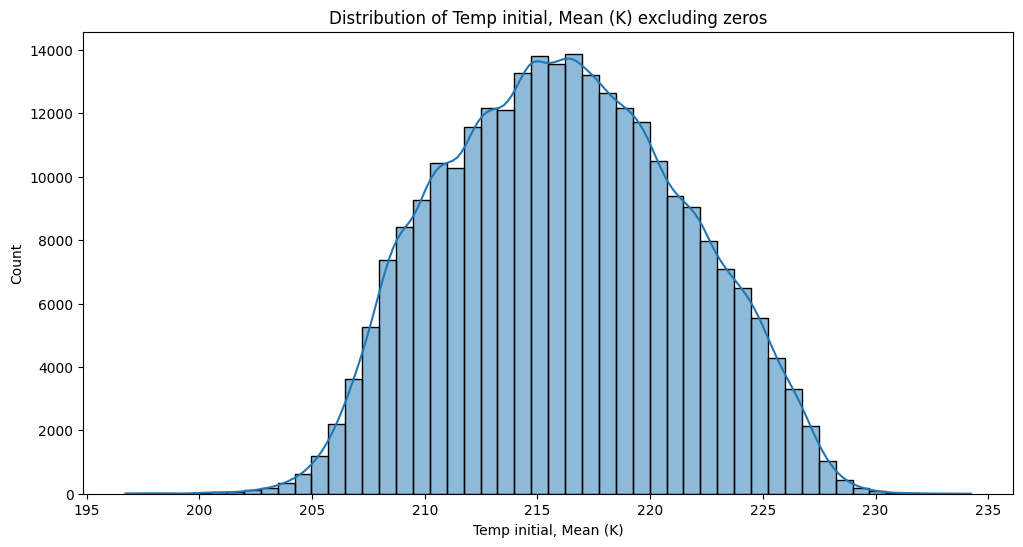

In [199]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(X['Temp initial, Mean (K)'], bins=50, kde=True)
plt.title('Distribution of Temp initial, Mean (K)')
plt.show()

# Visualizing without zeros to better understand the actual temperature distribution
plt.figure(figsize=(12, 6))
sns.histplot(X[X['Temp initial, Mean (K)'] > 0]['Temp initial, Mean (K)'], bins=50, kde=True)
plt.title('Distribution of Temp initial, Mean (K) excluding zeros')
plt.show()


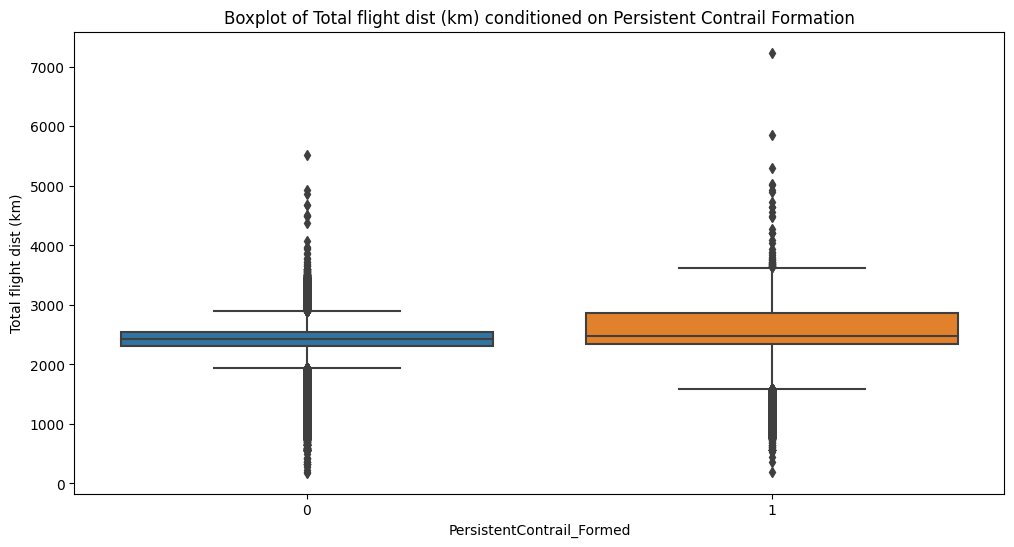

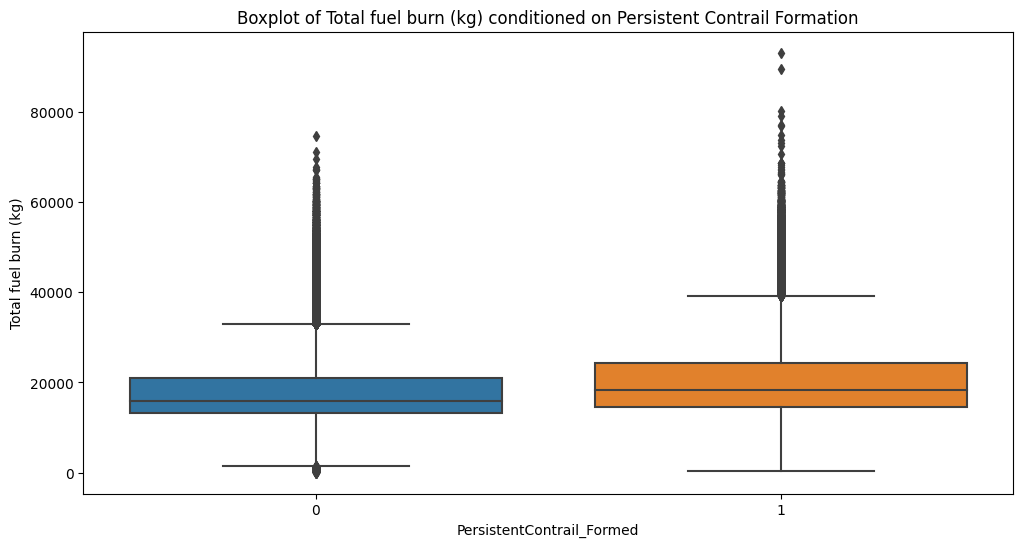

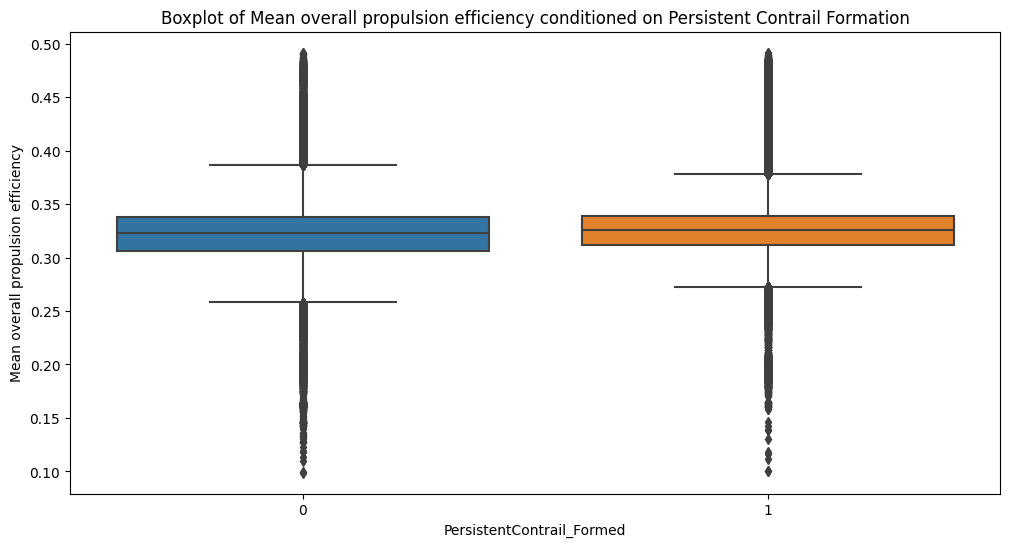

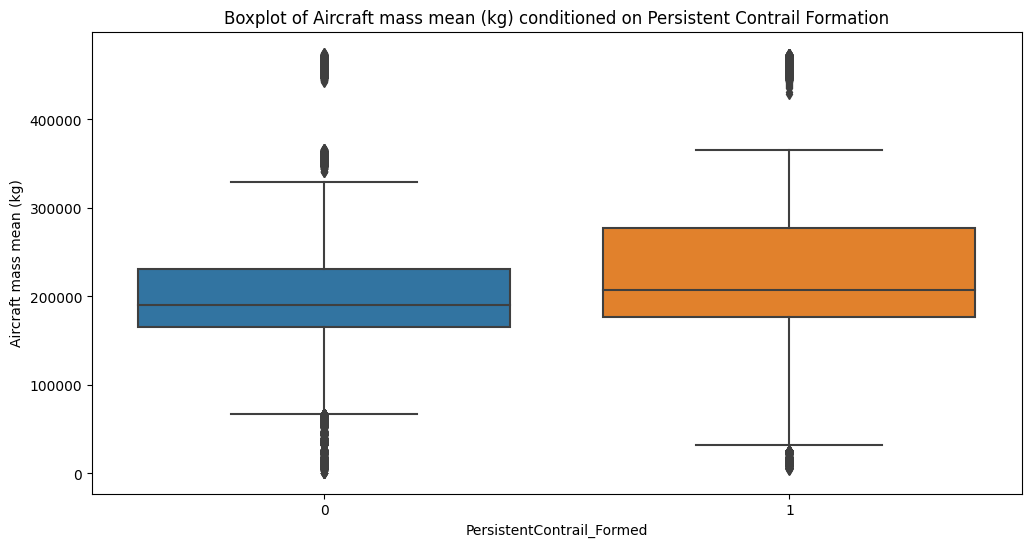

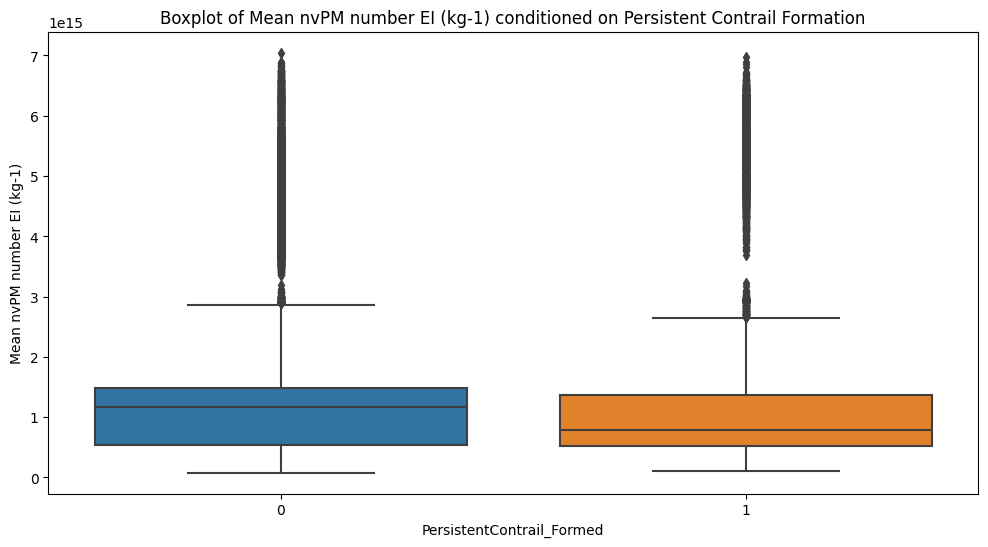

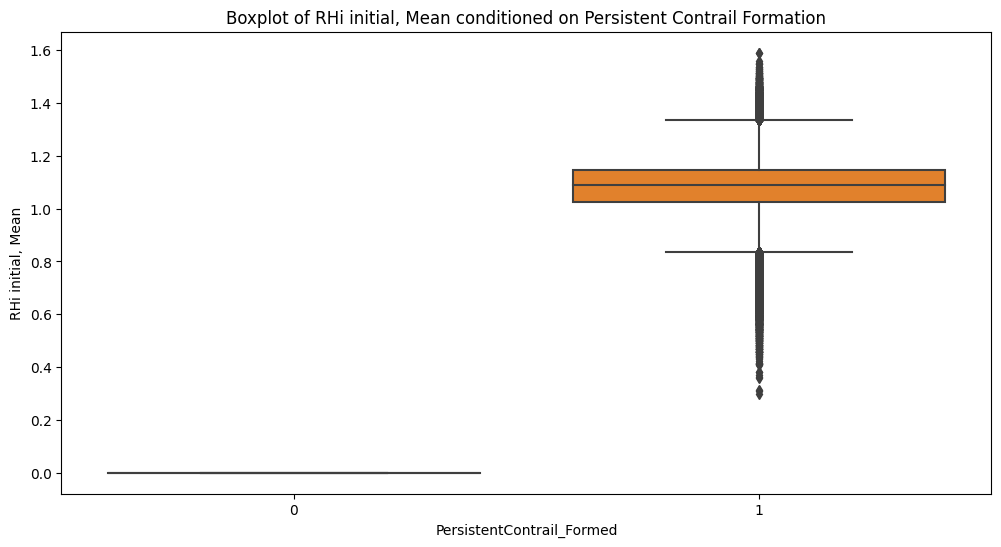

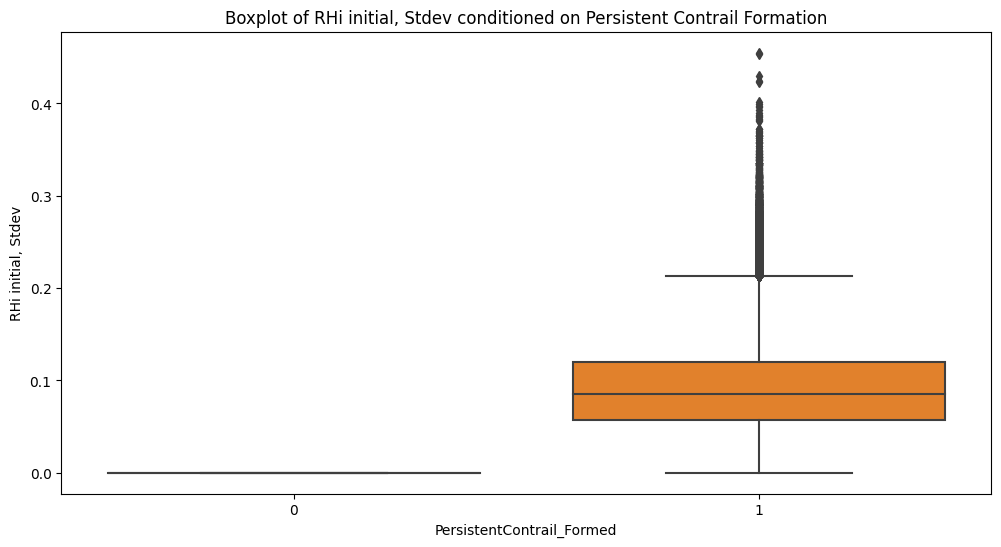

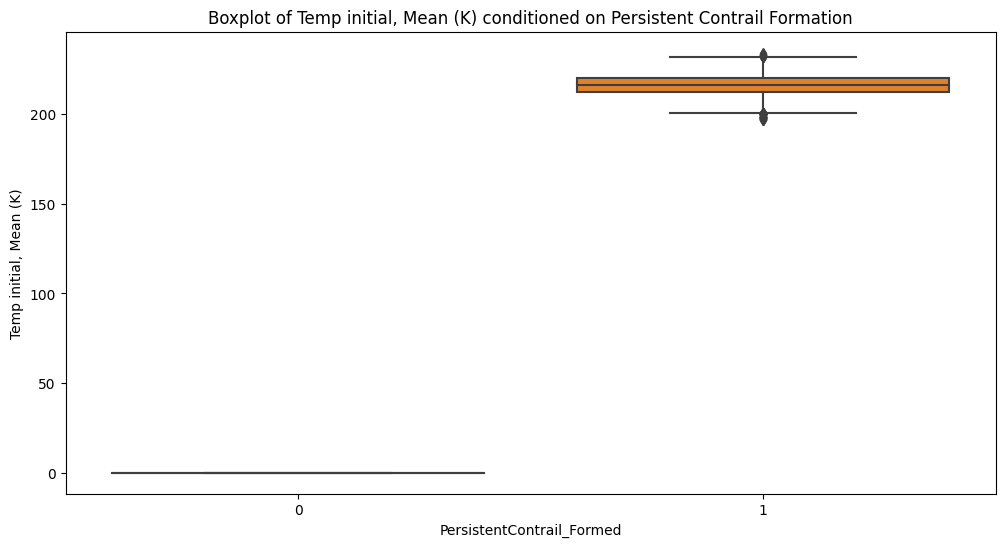

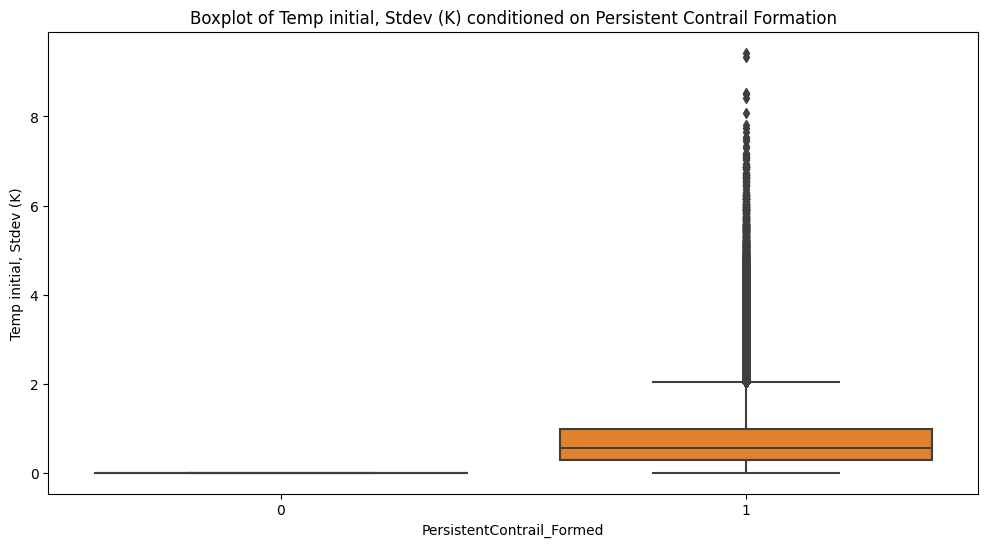

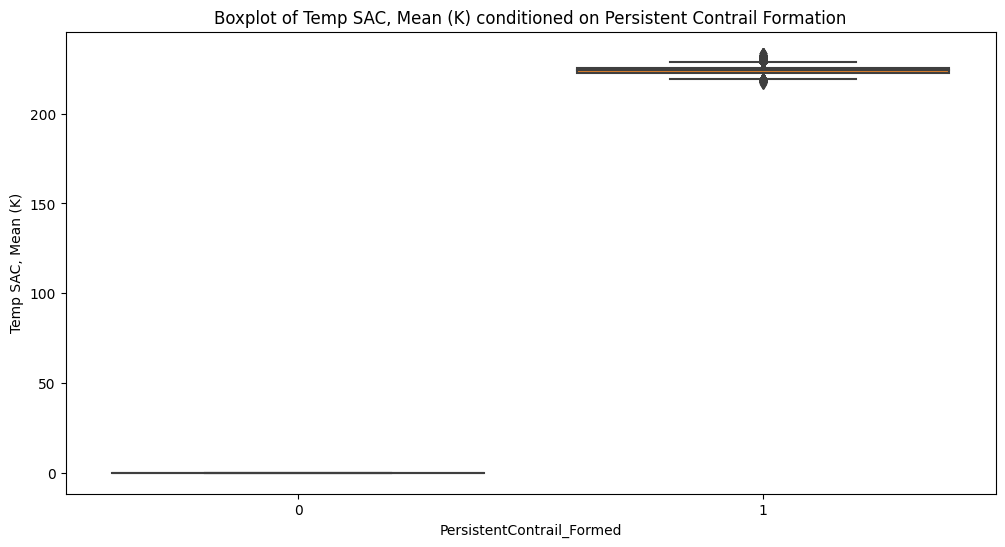

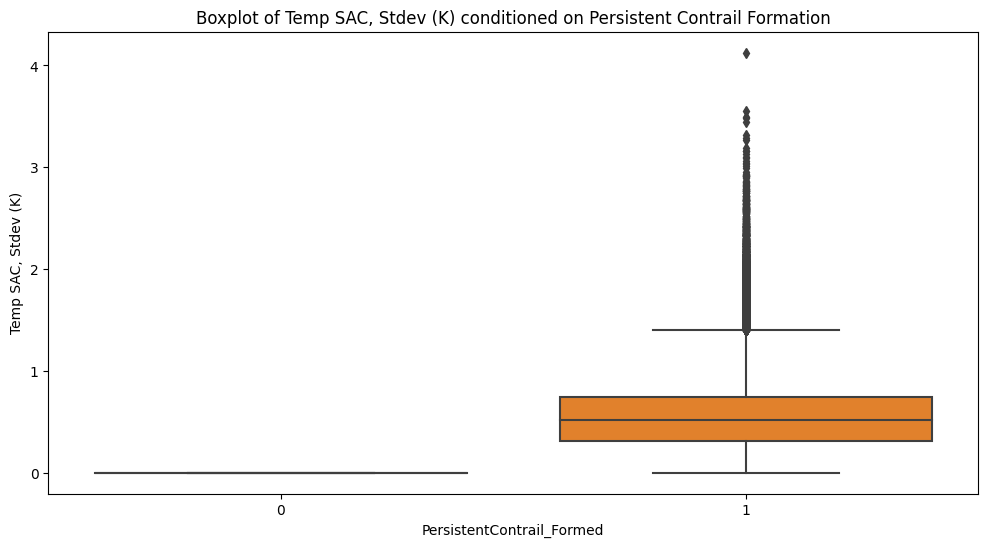

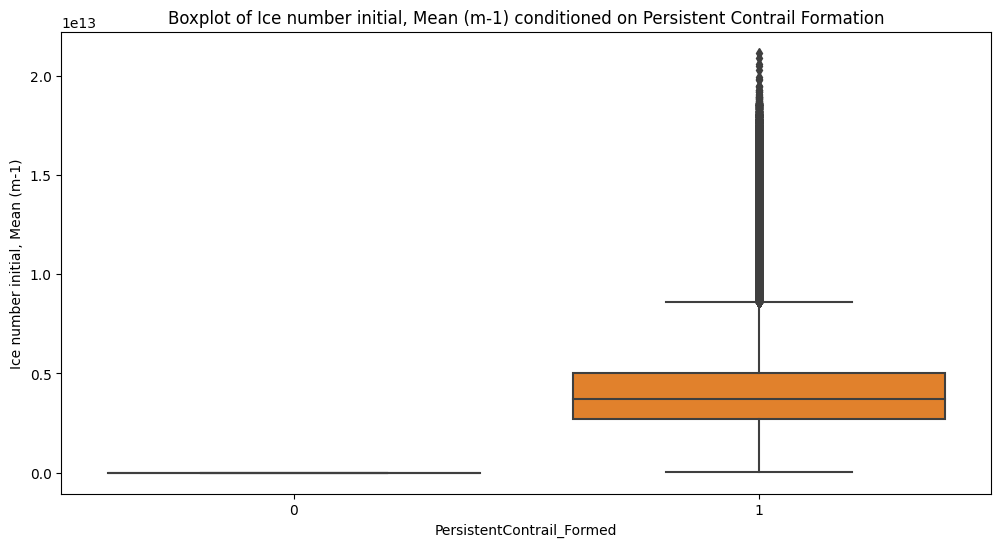

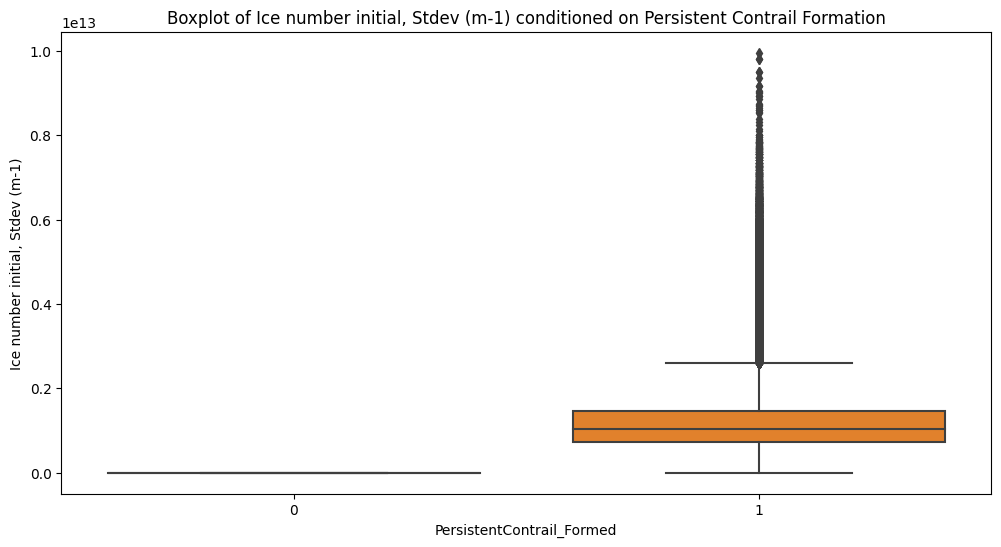

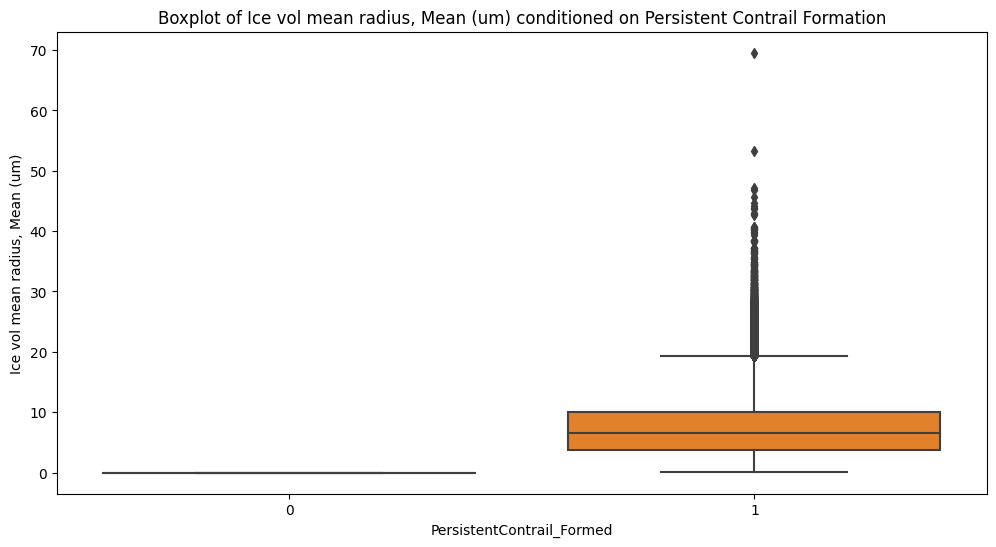

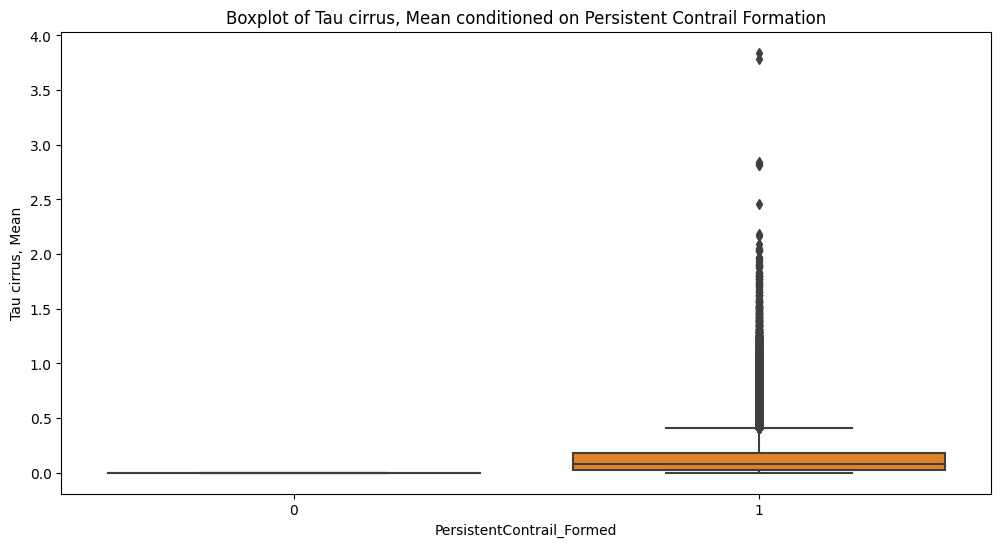

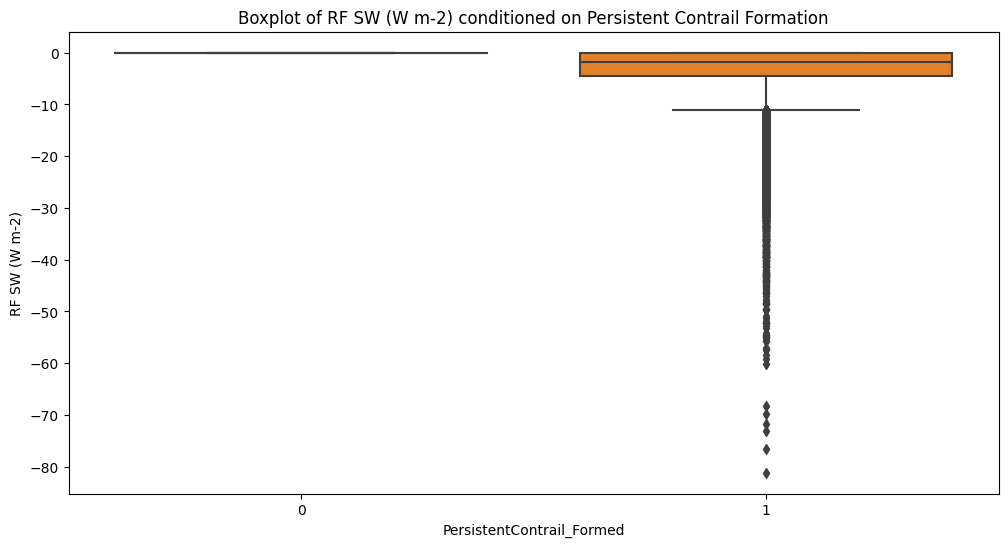

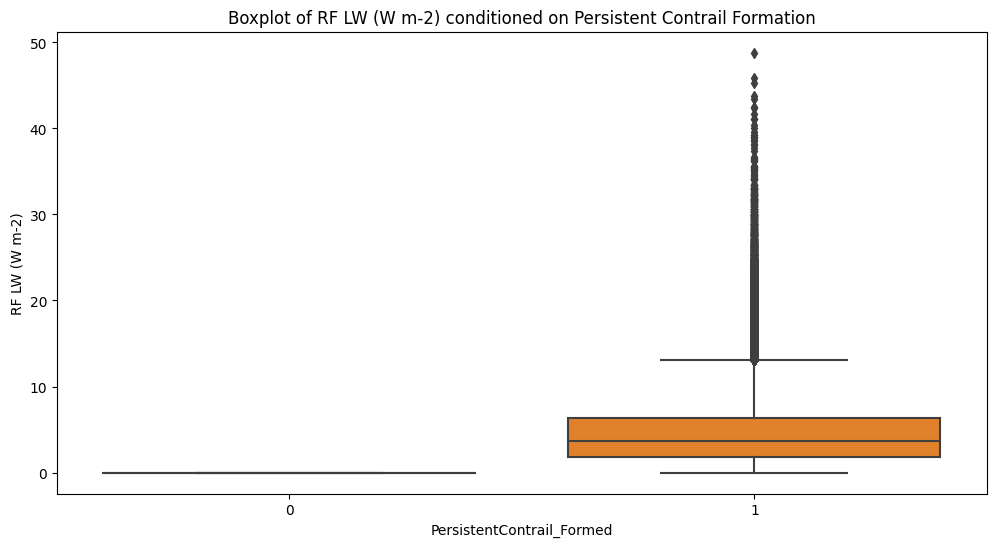

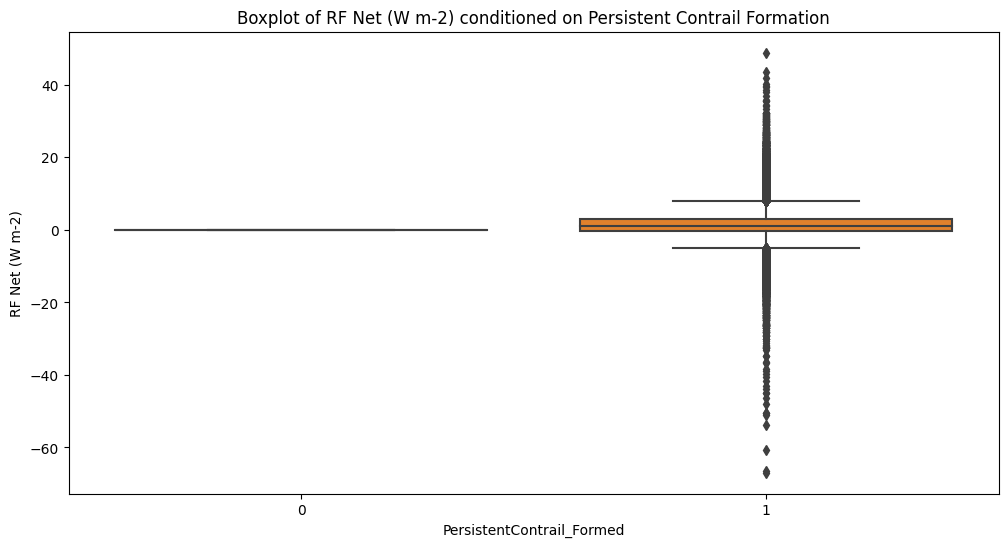

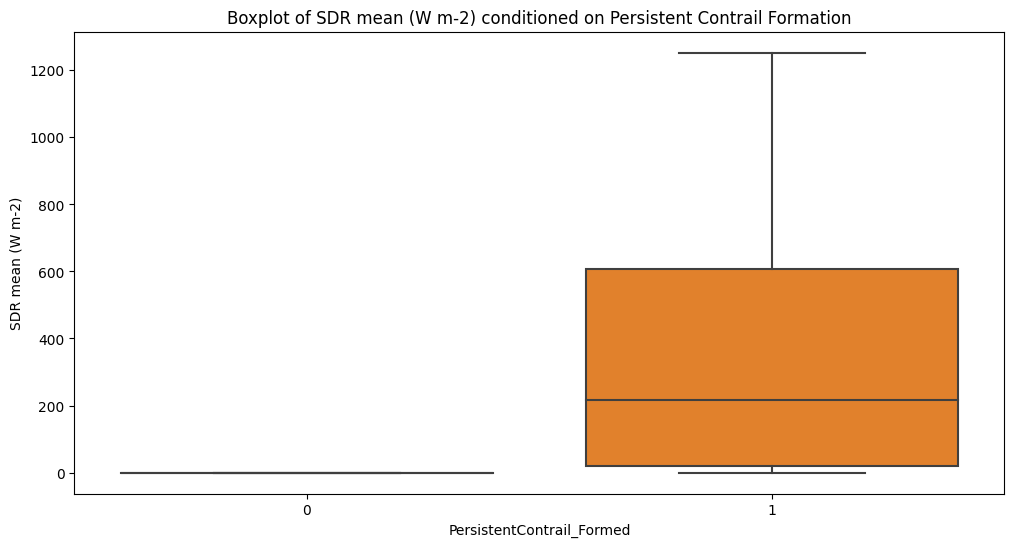

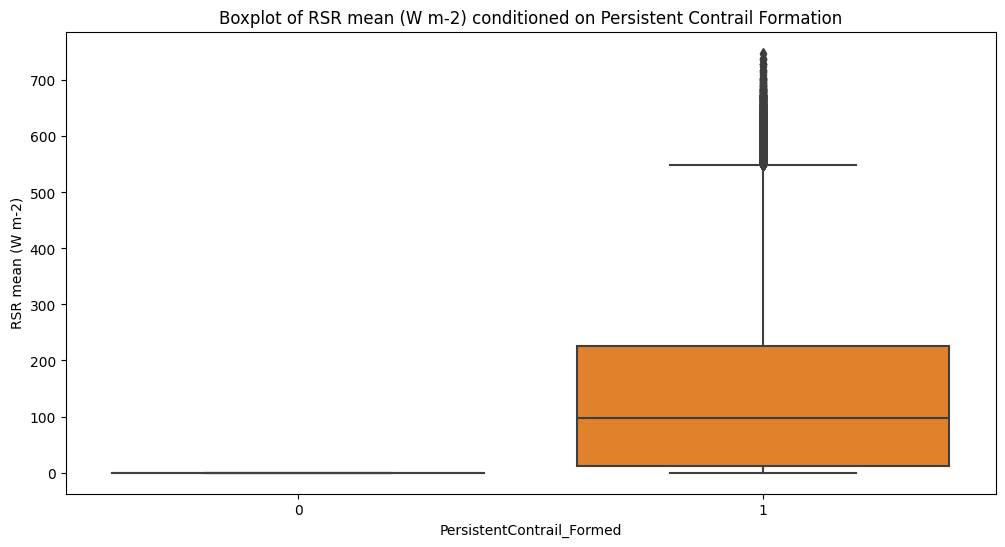

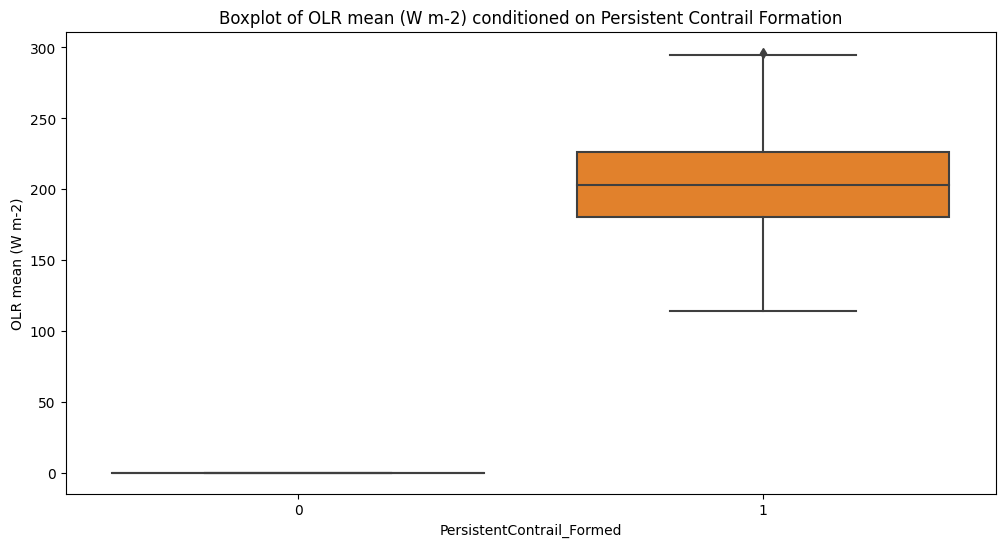

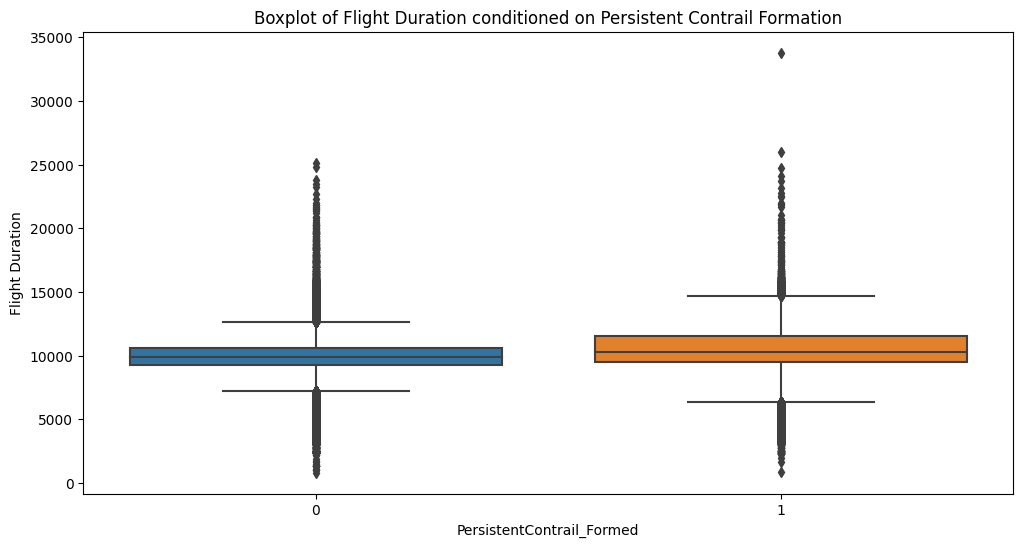

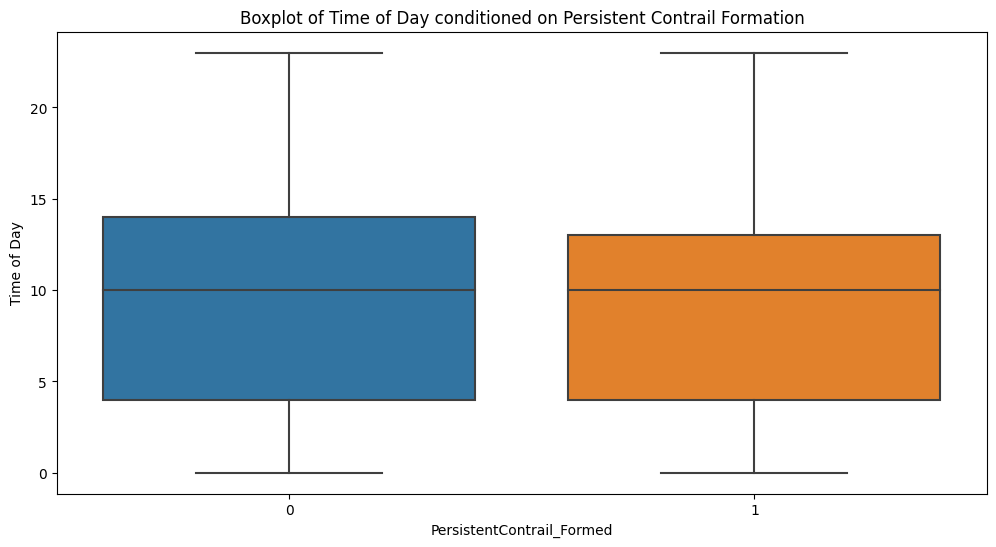

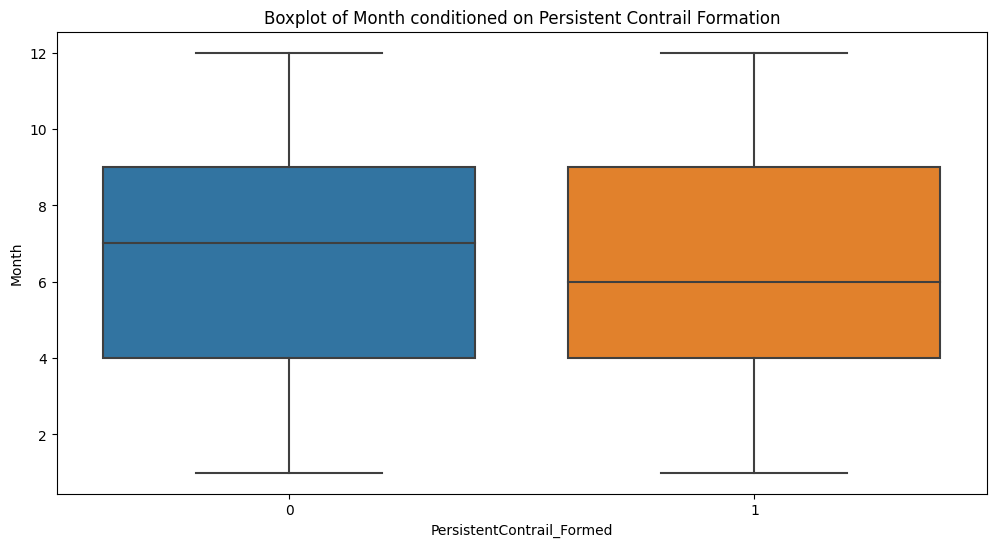

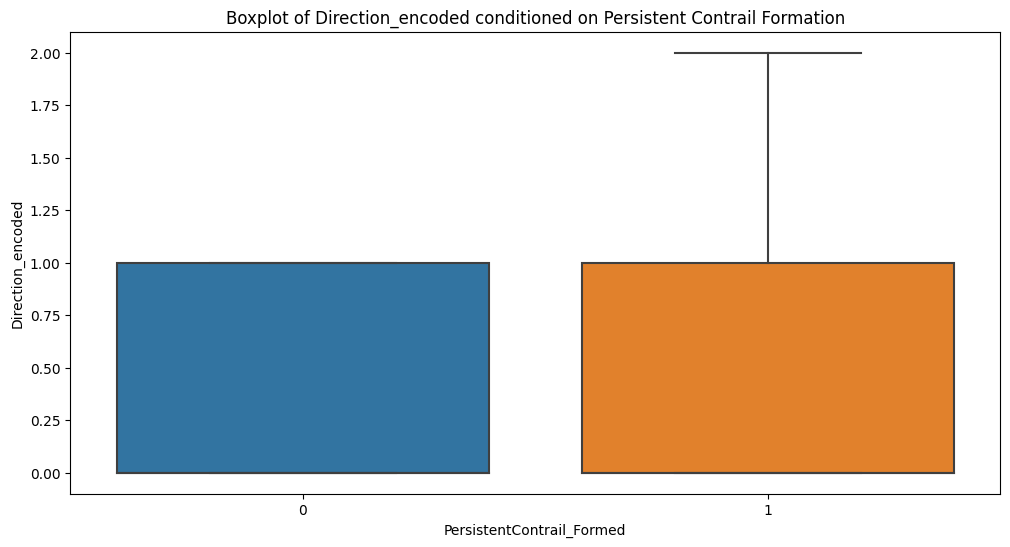

ValueError: ignored

<Figure size 1200x600 with 0 Axes>

In [201]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of feature columns
features = X.columns

for feature in features:
    plt.figure(figsize=(12,6))

    # If feature is numeric
    if X[feature].dtype in ['float64', 'int64']:
        sns.boxplot(x=y, y=X[feature])
        plt.title(f'Boxplot of {feature} conditioned on Persistent Contrail Formation')
    else: # If feature is categorical
        sns.countplot(x=feature, hue=y)
        plt.title(f'Distribution of {feature} by Persistent Contrail Formation')

    plt.show()
